In [98]:
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [84]:
from utils.common import (
    sigmoid, reverse_sigmoid,
    pad_column_name
)
from utils.constants import *
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, get_final_metric_df,
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric, 
    plot_score_distribution, train_logistic_regression
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols, plot_heatmap
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)

In [85]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
ID_COLUMNS = ["customer_ID", "target"]

### Read Data

In [81]:
labels = read_file(f"{RAW_DATA_PATH}/train_labels.csv")
target = labels["target"]
labels.head(2)

Shape of data: (458913, 2)


,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0


In [27]:
num_statements_df = read_file(f"{RAW_DATA_PATH}/train_num_statements.csv")
num_statements_df.head(2)

Shape of data: (458913, 2)


,customer_ID,num_statements
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,13


In [28]:
master_train_score_df = read_file(f"{EXP_PATH}/master_result/master_train_scores.csv")

Shape of data: (458913, 44)


In [29]:
master_train_score_df = master_train_score_df.loc[:, ID_COLUMNS + get_cols(master_train_score_df, "oof")]

In [30]:
train_score_c1 = read_file(f"{EXP_PATH}/chris/0.792648_custom_emb_local_best_no_sigmoid_skf_oof.csv")
train_score_c1 = train_score_c1.rename(columns={"oof_prediction": "chris_exp1_oof_score"})

Shape of data: (458913, 4)


In [31]:
master_train_score_df = master_train_score_df.merge(
    train_score_c1[ID_COLUMNS + ["chris_exp1_oof_score"]], on=ID_COLUMNS, how='left'
)

In [32]:
oof_columns = get_cols(master_train_score_df, "oof")

In [33]:
for col in oof_columns:
    metric = amex_metric(master_train_score_df["target"], master_train_score_df[col])
    print(f"{col.split('_')[0]}: OOF amex metric - {metric[0]:.5f}")

exp1: OOF amex metric - 0.79868
exp2: OOF amex metric - 0.79871
exp3: OOF amex metric - 0.79779
exp4: OOF amex metric - 0.79880
exp5: OOF amex metric - 0.79717
exp9: OOF amex metric - 0.79732
exp10: OOF amex metric - 0.79549
chris: OOF amex metric - 0.78706


In [34]:
# exp10 = train_score10.rename(
#     columns={k: "exp10_" + k.replace("score", "fold") + "_score" for k in score_col}
# ).rename(columns={"oof_score": "exp10_oof_score"}).drop(columns=["customer_ID", "target"])
# exp10.head()

### Train Logistic Regression

In [87]:
X_train = master_train_score_df.loc[:, oof_columns]
y_train = master_train_score_df.loc[:, "target"]

In [88]:
X_train = X_train.drop(columns=["exp3_oof_score", "exp5_oof_score", "exp10_oof_score"])

In [89]:
# X_train["temp1_oof_score"] = (X_train["chris_exp1_oof_score"] ** 2) * np.where(X_train["chris_exp1_oof_score"] > 0, 1, -1)

In [175]:
X_train.describe()

,exp1_oof_score,exp2_oof_score,exp4_oof_score,exp9_oof_score,chris_exp1_oof_score
count,458913.000000,458913.000000,458913.000000,458913.000000,458913.000000
mean,-2.670165,-2.601158,-2.707905,-2.644917,-2.028317
std,3.742455,3.642975,3.757464,3.693017,3.874062
min,-9.951277,-9.597510,-10.496748,-9.594308,-8.881240
25%,-5.852811,-5.721689,-5.898782,-5.794857,-5.390008
50%,-3.441199,-3.347013,-3.490815,-3.405300,-2.745373
75%,0.343257,0.359714,0.313746,0.348891,1.198648
max,9.244411,8.632654,9.233799,8.826942,7.899796


In [160]:
# Train a logistic regression unit on the OOF scores of my models
def train_logistic_regression(X_train, y_train, preprocess=None, 
                              verbose=0, random_state=42):
    scaler = None
    if preprocess is None:
        X_train_ = np.array(X_train)
    elif preprocess == "minmax":
        scaler = MinMaxScaler()
        X_train_ = scaler.fit_transform(X_train)
    elif preprocess == "standard":
        scaler = StandardScaler()
        X_train_ = scaler.fit_transform(X_train)
    elif preprocess == "sigmoid":
        X_train_ = X_train.copy()
        for col in X_train.columns:
            X_train_[col] = sigmoid(X_train[col])
        X_train_ = np.array(X_train)
    elif preprocess == "reverse_sigmoid":
        X_train_ = X_train.copy()
        for col in X_train.columns:
            X_train_[col] = reverse_sigmoid(X_train[col])
        X_train_ = np.array(X_train)
    else:
        X_train_ = np.array(X_train)
        print("GG preprocessing unknown")
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    metrics, train_metrics = [], []
    clf_list = []
    for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(X_train_, y_train)):
        X_tr, X_va = X_train_[idx_tr], X_train_[idx_va]
        y_tr, y_va = y_train[idx_tr], y_train[idx_va]
        clf = LogisticRegression(
            random_state=0,
            class_weight={0: 1, 1: 3.25},
            penalty="elasticnet",
            C=1.2,
            solver="saga",
            l1_ratio=0.3
        )
        clf.fit(X_tr, y_tr)
        clf_list.append(clf)
        y_train_pred = clf.predict_proba(X_tr)[:, 1]
        y_pred = clf.predict_proba(X_va)[:, 1]
        train_metric = amex_metric(y_tr.values, y_train_pred)[0]
        metric = amex_metric(y_va.values, y_pred)[0]
        metrics.append(metric)
        train_metrics.append(train_metric)
        
    if verbose:
        print(fold, train_metric, metric)
    
    df = pd.DataFrame(dict(val_amex_metric=metrics,
                           train_amex_metric=train_metrics))
    return df, clf_list, scaler

0.8003764660601483 0.8003906937312962


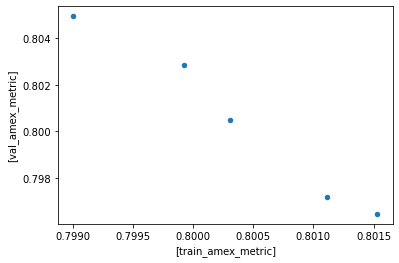

In [176]:
metrics_df, clf_list, scaler = train_logistic_regression(X_train, y_train)
print(metrics_df["train_amex_metric"].mean(), metrics_df["val_amex_metric"].mean())
metrics_df.plot.scatter(x=["train_amex_metric"], y=["val_amex_metric"])
plt.show()

In [178]:
# clf_list

In [179]:
preds = []
for clf in clf_list:
    preds.append(clf.predict_proba(X_train)[:, 1])

In [180]:
preds

[array([0.00104241, 0.00240168, 0.00179587, ..., 0.00376515, 0.26398386,
        0.00672782]),
 array([0.00102838, 0.00227922, 0.00173557, ..., 0.0036842 , 0.26544019,
        0.00675609]),
 array([0.00101844, 0.00230375, 0.00173776, ..., 0.00371849, 0.26316398,
        0.00669576]),
 array([0.00103088, 0.00235872, 0.00177679, ..., 0.00374397, 0.26474552,
        0.00673335]),
 array([0.00105417, 0.00238143, 0.00181667, ..., 0.0037387 , 0.26766352,
        0.00683897])]

In [181]:
preds = reverse_sigmoid(np.mean(preds, axis=0))

In [183]:
amex_metric(labels["target"], preds)

(0.8004888927704648, 0.926776418859676, 0.6742013666812535)

In [184]:
X_test_columns = [col.replace("oof_score", "average_test_score") for col in X_train.columns]

In [69]:
# result = pd.DataFrame(dict(boost_blend=preds, reg_residual=t8))

### Inference Logistic Regression

In [166]:
master_test_score_df = read_file(f"{EXP_PATH}/master_result/master_test_scores.csv")

Shape of data: (924621, 43)


In [167]:
test_score_c1 = read_file(f"{EXP_PATH}/chris/0.792648_custom_emb_local_best_no_sigmoid_skf.csv")
test_score_c1["prediction"] = test_score_c1["prediction"].apply(reverse_sigmoid)
test_score_c1 = test_score_c1.rename(columns={"prediction": "chris_exp1_average_test_score"})

Shape of data: (924621, 2)


In [168]:
master_test_score_df = master_test_score_df.merge(
    test_score_c1[["customer_ID", "chris_exp1_average_test_score"]], on="customer_ID", how='left'
)

In [187]:
# avg_columns = get_cols(master_test_score_df, "average")

In [188]:
X_test = master_test_score_df.loc[:, X_test_columns]

In [189]:
preds = []
for clf in clf_list:
    preds.append(clf.predict_proba(X_test)[:, 1])

In [190]:
preds = reverse_sigmoid(np.mean(preds, axis=0))

In [191]:
cid = read_file(f"{SUBMISSION_DATA_PATH}/empty.csv")
cid["prediction"] = preds
cid.to_csv(f"{SUBMISSION_DATA_PATH}/second_blend_with_chris_ye_model_adjust_logreg.csv", index=False)

Shape of data: (924621, 1)


In [78]:
sscaler = StandardScaler()
X_test_ = sscaler.fit_transform(X_test)

In [79]:
preds = []
for clf in clf_list:
    preds.append(clf.predict_proba(X_test_)[:, 1])

In [80]:
preds = reverse_sigmoid(np.mean(preds, axis=0))

In [81]:
preds

array([-4.12183385, -7.55791985, -3.50713887, ..., -0.2849554 ,
       -0.9373411 , -3.26565447])

In [71]:
# X_test["sign"] = X_test.iloc[:, :6].apply(lambda x: 1 if sum([i > 0 for i in x]) > 0 else -1, axis=1)
# X_test["sign"].value_counts(normalize=True)
# X_test["final"] = X_test["sign"] * X_test.iloc[:, :6].product(axis=1)
# X_test["final"]

In [82]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = preds
sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission_22TH_blend_4_best_local_darts.csv", index=False)

In [271]:
X_test_ = mscaler.fit_transform(X_test_)

In [272]:
preds = []
for clf in clf_list:
    preds.append(clf.predict_proba(X_test_)[:, 1])

In [273]:
final_score = np.mean(preds, axis=0)

In [295]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = test_score9.mean(axis=1)
sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission_20TH_vanilla_experiment9_seed_1234_average.csv", index=False)

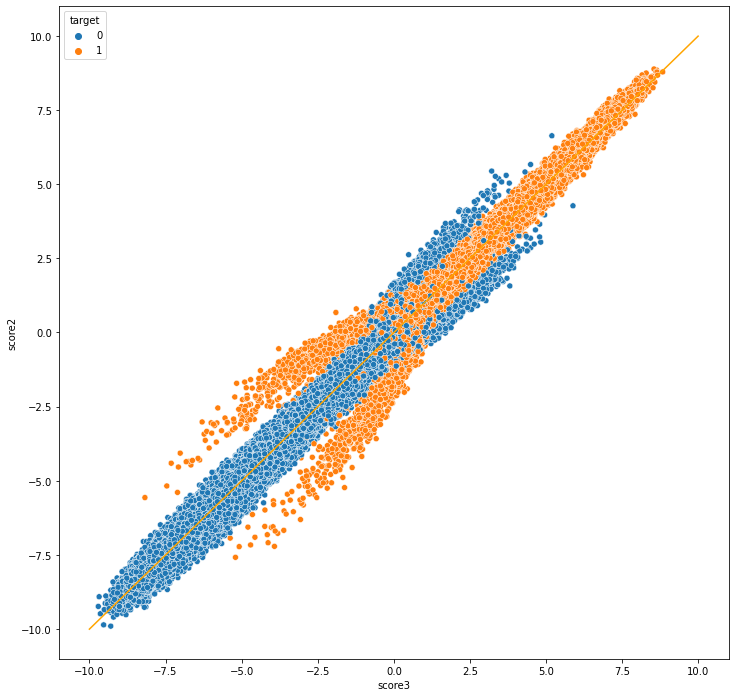

In [288]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x=train_score9["score3"], y=train_score9["score2"], hue=train_score9["target"])
plt.plot(np.arange(-10, 10, 0.01), np.arange(-10, 10, 0.01), color="orange", linestyle="-")
plt.show()

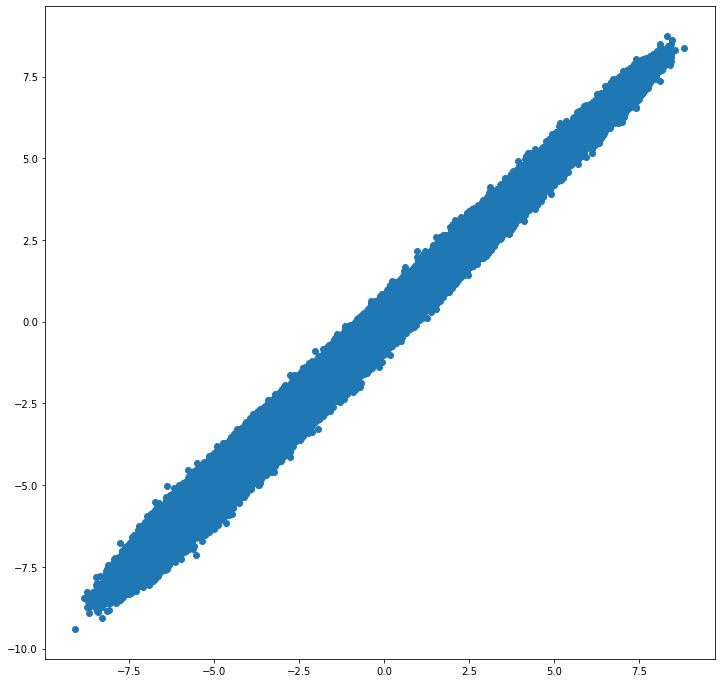

In [291]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(test_score9["score3"], test_score9["score4"])
plt.show()

In [320]:
X_train_

array([[-8.02558655, -7.53088904, -7.79839396, -7.60327302],
       [-6.99587721, -7.35056828, -6.93377296, -6.69328752],
       [-7.18439325, -7.41133143, -7.42501141, -6.87409778],
       ...,
       [-6.70857283, -6.57018898, -6.23910077, -6.91964404],
       [-1.92453839, -1.77250317, -2.02940995, -1.83362764],
       [-6.05023009, -5.61319556, -5.86492798, -6.06270989]])

### END

In [434]:
# mscaler = StandardScaler()
# result = pd.DataFrame(mscaler.fit_transform(result), columns=result.columns)

In [435]:
top_thr = np.percentile(result["boost_blend"], 80)
mid_thr = np.percentile(result["boost_blend"], 70)
btm_thr = np.percentile(result["boost_blend"], 10)

In [436]:
(result["boost_blend"] >= top_thr).sum()

91783

In [437]:
result.loc[:, "final"] = np.where(
    (result["boost_blend"] >= top_thr), # & (result["reg_residual"] < 0), 
    0.9 * result["boost_blend"] + 0.1 * (result["reg_residual"] + 5),
    result["boost_blend"],
)

In [438]:
result.loc[:, "final"] = np.where(
    (result.loc[:, "final"].between(mid_thr, top_thr)) & (result["reg_residual"] > 0), 
    0.9 * result["final"] + 0.1 * (result["reg_residual"] - 0.25),
    result["final"],
)

In [439]:
result["target"] = labels['target'].values

In [440]:
amex_metric(labels["target"], result["final"])

(0.7998247588149134, 0.9266179089180755, 0.6730316087117515)

In [239]:
result = get_final_metric_df(result, pred_col="boost_blend").reset_index(drop=True)

In [240]:
result.loc[result["is_cutoff"] == 1].groupby("target")["reg_residual"].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,13598.0,4.758301,1.977495,-1.710416,3.497045,4.693073,5.934894,29.439524
1,4846.0,4.792826,1.998559,-1.271347,3.508093,4.728712,6.010576,23.135658


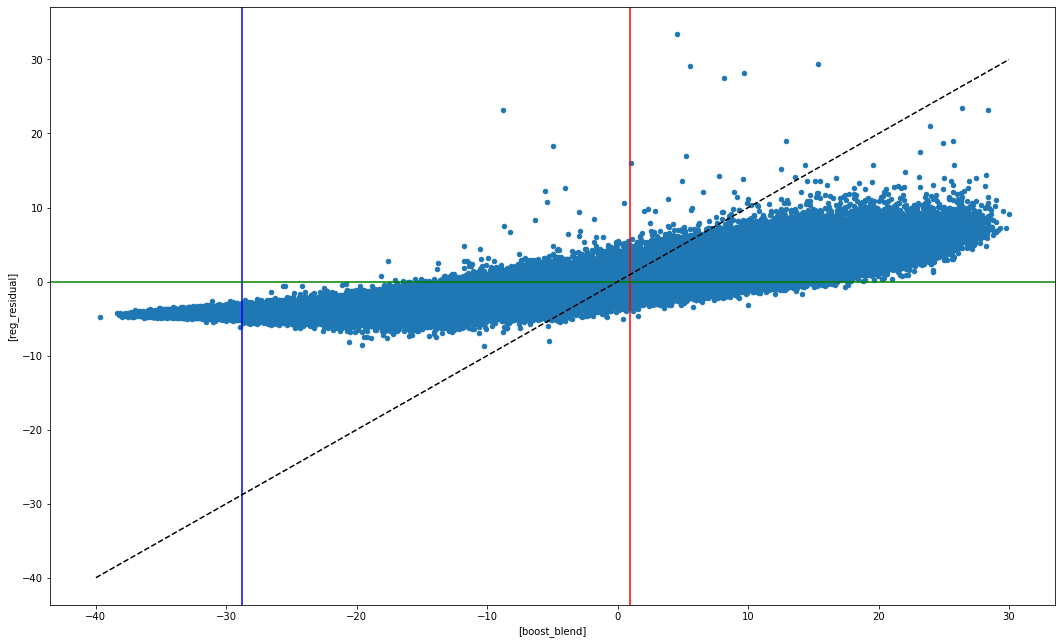

In [241]:
fig, ax = plt.subplots(figsize=(18, 11))
result.plot.scatter(x=["boost_blend"], y=["reg_residual"], ax=ax)
plt.axvline(top_thr, color="red")
plt.axvline(btm_thr, color="blue")
plt.axhline(0, color="green")
plt.plot(np.arange(-40, 30, 0.01), np.arange(-40, 30, 0.01), color="black", linestyle="--")
plt.show()

In [71]:
# result.describe()

In [521]:
X_train["sign"] = X_train.iloc[:, :6].apply(lambda x: 1 if sum([i > 0 for i in x]) > 1 else -1, axis=1)

In [522]:
X_train["sign"].value_counts(normalize=True)

-1    0.715992
 1    0.284008
Name: sign, dtype: float64

In [518]:
X_train["final"] = X_train["sign"] * X_train.iloc[:, :6].product(axis=1)

In [519]:
X_train["final"]

0        -203468.541018
1        -102736.605618
2        -140737.946632
3         -25020.982157
4         -70787.711285
              ...      
458908    -31451.276826
458909     -2280.955991
458910    -84882.479784
458911       -41.686937
458912    -42103.262310
Name: final, Length: 458913, dtype: float64

In [520]:
amex_metric(X_train["target"].values, X_train["final"].values)

(0.7995833576869003, 0.9263791568859019, 0.6727875584878985)

In [498]:
amex_metric(X_train["target"].values, X_train["final"].values)

(0.7995896537645171, 0.9263917490411357, 0.6727875584878985)

In [421]:
X_train_["max"] = X_train_.iloc[:, :5].max(axis=1)
X_train_["min"] = X_train_.iloc[:, :5].min(axis=1)
X_train_["median"] = X_train_.iloc[:, :5].median(axis=1)
X_train_["mean"] = X_train_.iloc[:, :5].mean(axis=1)
X_train_["skew"] = X_train_.iloc[:, :5].skew(axis=1)
X_train_["std"] = X_train_.iloc[:, :5].std(axis=1)

In [422]:
# X_train_["median_larger"] = (X_train_["median"] > X_train_["mean"]).astype(int)

In [423]:
X_train_["positive_skew"] = (X_train_["skew"] > 0).astype(int)

In [424]:
X_train_["high_std"] = (X_train_["std"] > 0.2).astype(int)

In [425]:
X_train_["is_full_statements"] = np.where(num_statements_df["num_statements"] == 13, 1, 0)

In [426]:
# X_train_.groupby("high_std")["target"].mean()

In [427]:
# X_train_.groupby("median_larger")["target"].mean()

In [428]:
def train_logistic_regression(X_train, y_train, min_max_scaled=True, random_state=1020):
    if min_max_scaled:
        mscaler = MinMaxScaler()
        X_train_ = mscaler.fit_transform(X_train)
    else:
        mscaler = ''
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    metrics, train_metrics = [], []
    clf_list = []
    for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(X_train_, y_train_)):
        X_tr, X_va = X_train_[idx_tr], X_train_[idx_va]
        y_tr, y_va = y_train_[idx_tr], y_train_[idx_va]
        clf = LogisticRegression(
            random_state=0,
            class_weight=[0.8, 0.2],
            penalty="l2"
        )
        clf.fit(X_tr, y_tr)
        clf_list.append(clf)
        y_train_pred = clf.predict_proba(X_tr)[:, 1]
        y_pred = clf.predict_proba(X_va)[:, 1]
        train_metric = amex_metric(y_tr.values, y_train_pred)[0]
        metric = amex_metric(y_va.values, y_pred)[0]
        metrics.append(metric)
        train_metrics.append(train_metric)
        print(fold, train_metric, metric)
        
    return np.mean(metrics), mscaler, clf_list

In [429]:
y_train = target

In [431]:
X_train_ = X_train_.drop(columns=["median", "skew", "std"], errors='ignore')

In [433]:
X_train_.drop(columns=get_cols(X_train_, "oof"), inplace=True)

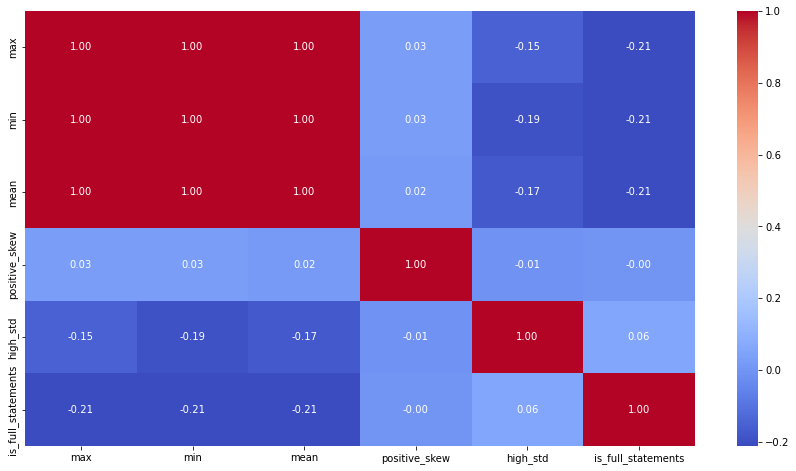

In [435]:
plot_heatmap(X_train_.corr(), annot=True, fmt=".2f")

In [436]:
final_oof_score, min_max_scaler, clf_list = train_logistic_regression(X_train_, y_train_)

1 0.8000615133263818 0.7974836564826935
2 0.7999891714062497 0.7979710690443198
3 0.7992819320851674 0.8006549485063224
4 0.7992045783600361 0.8015070836906751
5 0.7993032805950401 0.8009747880596201


In [437]:
final_oof_score

0.7997183091567261

In [304]:
final_oof_score, min_max_scaler = train_logistic_regression(X_train_, y_train_)

1 0.800443744438765 0.7977839747573845
2 0.8004454425449861 0.7980198655419419
3 0.7996422732225261 0.8010617674997593
4 0.799687983094375 0.8015466264779496
5 0.7995645376966464 0.8015415139936592


In [364]:
# final_oof_score

In [186]:
y_pred = pd.Series(X_train_.iloc[:, 1:].mean(axis=1), name="prediction")
y_true = labels[["target"]]

In [190]:
result = get_final_metric_df(X_train_, y_true, y_pred)
# result

In [131]:
default_df = result.loc[result["target"] == 1]
non_default_df = result.loc[result["target"] == 0]

In [132]:
result.loc[default_df.index, "ground_truth"] = 10 - default_df["prediction"]
result.loc[non_default_df.index, "ground_truth"] = -10 - non_default_df["prediction"]

In [191]:
# result.sort_index()["ground_truth"].to_csv(f"{RAW_DATA_PATH}/oof_residuals.csv", index=False)

In [75]:
y_train_ = train_score1["target"]

In [77]:
X_tr, X_va, y_tr, y_va = train_test_split(X_train_, y_train_, test_size=0.2, random_state=1020, stratify=y_train_)

In [78]:
# RandomForestClassifier(
#     random_state=1020,
#     n_estimators=16,
#     max_depth=3
# )

In [259]:
clf_list

[LogisticRegression(class_weight=[0.8, 0.2], random_state=0),
 LogisticRegression(class_weight=[0.8, 0.2], random_state=0),
 LogisticRegression(class_weight=[0.8, 0.2], random_state=0),
 LogisticRegression(class_weight=[0.8, 0.2], random_state=0),
 LogisticRegression(class_weight=[0.8, 0.2], random_state=0)]

In [309]:
train_logistic_regression(train_score9.iloc[:, 1:6], train_score9["target"])

1 0.9177395453552648 0.9147245439781231
2 0.9176590112157511 0.9154084195918446
3 0.9168789304266861 0.9178542129526484
4 0.9170827886312676 0.917669110876592
5 0.9162863591277919 0.919863841202062


(0.917104025720254, MinMaxScaler())

In [276]:
test_score9[["score1",

,score1,score2,score3,score4,score5
0,-3.821564,-3.461997,-3.348870,-3.586271,-3.312073
1,-6.860182,-6.537879,-6.262872,-6.682696,-6.887376
2,-3.013238,-3.461611,-3.004113,-3.050773,-3.447362
3,-0.770930,-0.884658,-0.407027,-0.646863,-0.650042
4,2.198048,2.433070,2.088249,2.327092,2.377117
...,...,...,...,...,...
924616,-3.365608,-3.708212,-3.481497,-3.755893,-3.605609
924617,2.205423,1.850653,2.136378,2.145076,1.963180
924618,-0.259439,0.104114,-0.125630,-0.281783,0.016716
924619,-0.713172,-0.414007,-0.342954,-0.312344,-0.337855


In [297]:
test_score9

,score1,score2,score3,score4,score5
0,-3.821564,-3.461997,-3.348870,-3.586271,-3.312073
1,-6.860182,-6.537879,-6.262872,-6.682696,-6.887376
2,-3.013238,-3.461611,-3.004113,-3.050773,-3.447362
3,-0.770930,-0.884658,-0.407027,-0.646863,-0.650042
4,2.198048,2.433070,2.088249,2.327092,2.377117
...,...,...,...,...,...
924616,-3.365608,-3.708212,-3.481497,-3.755893,-3.605609
924617,2.205423,1.850653,2.136378,2.145076,1.963180
924618,-0.259439,0.104114,-0.125630,-0.281783,0.016716
924619,-0.713172,-0.414007,-0.342954,-0.312344,-0.337855


### BLEND TEST

Shape of data: (924621, 5)
Shape of data: (924621, 5)
Shape of data: (924621, 5)
Shape of data: (924621, 5)
Shape of data: (924621, 5)


In [20]:
s = read_file(f"{SUBMISSION_DATA_PATH}/submission3_lgbm_dart_full_fix_1020.csv")["prediction"]

Shape of data: (924621, 2)


In [26]:
s2 = test_score2.mean(axis=1)

In [64]:
m = MinMaxScaler()

In [33]:
test_score2_ = m.fit_transform(test_score2)

In [35]:
np.mean(test_score2_, axis=1)

array([0.32552628, 0.14096738, 0.35586654, ..., 0.52899043, 0.49217374,
       0.36775012])

In [36]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = np.mean(test_score2_, axis=1)
sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission_9TH_seed_1020_average_fold_after_minmaxscaler.csv", index=False)

In [67]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = (
    (0.4 * m.fit_transform(test_score1).mean(axis=1)) + 
    (0.1 * m.fit_transform(test_score2).mean(axis=1)) + 
    (0.2 * m.fit_transform(test_score3).mean(axis=1)) + 
    (0.1 * m.fit_transform(test_score4).mean(axis=1)) +
    (0.1 * m.fit_transform(test_score5).mean(axis=1))
) / 0.9
sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission_10TH_blend_5_own_seeds_after_min_max_scaled.csv", index=False)

In [68]:
sub["prediction"].describe()

count    924621.000000
mean          0.385767
std           0.194353
min           0.000000
25%           0.220337
50%           0.344674
75%           0.538963
max           0.994977
Name: prediction, dtype: float64

In [7]:
## 1ST - 0.799 (medium)
amex_metric(train_score1["target"], t1)

(0.7986772206700369, 0.9259891065704908, 0.6713653347695829)

In [8]:
## 3RD - 0.800 (low)
amex_metric(train_score1["target"], t2)

(0.7987062094874274, 0.9260807463051137, 0.6713316726697411)

In [9]:
## 5TH - 0.799 (low)
amex_metric(train_score1["target"], t3)

(0.797788577455728, 0.925642459385149, 0.6699346955263069)

In [10]:
### 6TH - 0.800 (very low)
amex_metric(train_score1["target"], t4)

(0.7987959566465116, 0.9262181629984798, 0.6713737502945434)

In [11]:
### 7TH - 0.798 (high)
amex_metric(train_score1["target"], t5)

(0.7971742806455548, 0.9257687652834348, 0.6685797960076749)